## **Install necessary libraries**

In [4]:
!pip install ipywidgets
!pip install deepface
!pip install ultralytics
!pip install git+https://github.com/huggingface/transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 34.2 MB/s eta 0:00:00a 0:00:01
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114248 sha256=84c02c7a363792fa2417e0ef37a45e9d9b06fd565a7ec1380f9718a5b212cf46
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-ipvf20ax
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-ipvf20ax
  Resolved https://github.com/huggingface/transformers to commit 1d063793318b20654ebb850f48f43e0a247ab7bb
  Installing build dependencies ... don

## **Import all libraries**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import glob
import os
import imageio
import cv2
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt
import ipywidgets as widgets
from deepface import DeepFace
from ultralytics import YOLO
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
import requests
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from bs4 import BeautifulSoup
import string
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Normalization
import pickle

24-10-26 07:06:11 - Directory /root/.deepface has been created
24-10-26 07:06:11 - Directory /root/.deepface/weights has been created
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## **Upload image**

In [20]:
# Step 1: Create a file upload widget
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)
display(upload_widget)

uploaded_image = None
uploaded_image_path = None

# Step 2: Define a function to handle the uploaded file
def on_upload_change(change):
    global uploaded_image, uploaded_image_path
    
    if change['new']:
        # Get the uploaded file information
        uploaded_file = list(change['new'].values())[0]
        image_name = uploaded_file['metadata']['name']
        uploaded_image_path = f'./{image_name}'
        
        # Save the uploaded image content to a local file
        with open(uploaded_image_path, 'wb') as f:
            f.write(uploaded_file['content'])
        
        # Open and display the image
        uploaded_image = Image.open(uploaded_image_path)
        plt.imshow(uploaded_image)
        plt.axis('off')
        plt.show()
        
        # Print the image path or other details
        print(f"Uploaded image saved as: {uploaded_image_path}")
        print(f"Image size: {uploaded_image.size}")

# Step 3: Attach the file upload handler
upload_widget.observe(on_upload_change, names='value')

FileUpload(value={}, accept='image/*', description='Upload')

## **Face Extraction**

In [21]:
# Global variable to store the cropped face
cropped_face = None

def process_uploaded_image():
    global uploaded_image, uploaded_image_path, cropped_face

    if uploaded_image is None or uploaded_image_path is None:
        print("No image uploaded.")
        return

    # Convert the uploaded image to a format suitable for OpenCV (numpy array)
    img_array = np.array(uploaded_image)

    # Convert from RGB (PIL format) to BGR (OpenCV format)
    img = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)

    # Face detection using Haar Cascade
    face_engine = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_engine.detectMultiScale(img, scaleFactor=1.3, minNeighbors=5)

    if len(faces) > 0:
        max_area = 0
        max_cordinate = None

        # Find the largest face
        for (x, y, w, h) in faces:
            area = h * w
            if area > max_area:
                max_area = area
                max_cordinate = (x, y, w, h)

        # Crop and resize the largest face
        if max_cordinate is not None:
            cropped = img[max_cordinate[1]:max_cordinate[1] + max_cordinate[3], max_cordinate[0]:max_cordinate[0] + max_cordinate[2]]
            cropped_face = cv2.resize(cropped, (128, 128), interpolation=cv2.INTER_AREA)
            print("Cropped face stored in global variable.")
        else:
            print("No face detected in the image.")
    else:
        print("No faces found.")

# # Example usage
# process_uploaded_image()

# # Access the cropped face if it exists
# if cropped_face is not None:
#     # Display the cropped face using matplotlib
#     import matplotlib.pyplot as plt

#     plt.imshow(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))
#     plt.axis('off')
#     plt.show()
# else:
#     print("No cropped face is available.")


## **Finding Face attributes**
(Emotion, race, age, age_group, gender)

In [22]:
# Global variable to store the analysis results
result = None

def analyze_single_image():
    global cropped_face, result

    if cropped_face is None:
        print("No cropped face image available.")
        return

    try:
        # Analyze the image for emotion, race, gender, and age
        predictions = DeepFace.analyze(cropped_face, actions=["emotion", "race", "gender", "age"], enforce_detection=False)

        # Check if predictions is a list and has at least one item
        if isinstance(predictions, list) and len(predictions) > 0:
            dominant_emotion = predictions[0]['dominant_emotion']
            dominant_race = predictions[0]['dominant_race']
            gender_scores = predictions[0]['gender']  # This is a dict with probabilities

            # Extract the dominant gender based on the scores
            if gender_scores['Woman'] > gender_scores['Man']:
                dominant_gender = 'Female'
            else:
                dominant_gender = 'Male'

            age = predictions[0]['age']

            # Bucket the age
            if 13 <= age <= 17:
                agebucket = '13-17 years'
            elif 18 <= age <= 24:
                agebucket = '18-24 years'
            elif 25 <= age <= 34:
                agebucket = '25-34 years'
            elif 35 <= age <= 44:
                agebucket = '35-44 years'
            elif 45 <= age <= 54:
                agebucket = '45-54 years'
            elif 55 <= age <= 64:
                agebucket = '55-64 years'
            elif age > 64:
                agebucket = 'above 65 years'
            else:
                agebucket = 'NA'

            # Store the analysis results in the global variable
            result = {
                'Dominant Emotion': dominant_emotion,
                'Dominant Race': dominant_race,
                'Dominant Gender': dominant_gender,  # Store only "Male" or "Female"
                'Age': age,
                'Age Group': agebucket
            }

            # Print the results
            print("Analysis Results:")
            print(result)

        else:
            result = 'NA'  # Handle case where predictions are not valid

    except Exception as e:
        result = 'NA'  # If there is an error during processing
        traceback.print_exc()  # Print traceback for debugging

# # Call the function to analyze the cropped face
# analyze_single_image()

# # Access the results from the global variable
# if result is not None:
#     print("Analysis stored in global variable:")
#     print(result)
# else:
#     print("No analysis results available.")


In [23]:
print(result)

None


## **Object Detection**

In [24]:
detected_objects = None  # This will store the results from the detection function


def detect_objects_with_unique_labels(uploaded_image_path):
    global detected_objects
    detection_results = None
    # Check if the uploaded image path is set
    if uploaded_image_path is None:
        print("No image path provided.")
        return
    
    # Load the pre-trained YOLOv8 model
    model = YOLO("yolov8n.pt")  # Ensure the path to the YOLO model is correct

    # Perform object detection
    results = model(uploaded_image_path)

    # Dictionary to keep count of each detected object
    object_count = {}
    detected_objects = []

    # Extract detected object names with unique labels
    for result in results:
        for obj in result.boxes.data:
            # Get the class id and name of the detected object
            class_id = int(obj[5].item())
            class_name = model.names[class_id]

            # Update the count for this object
            if class_name in object_count:
                object_count[class_name] += 1
            else:
                object_count[class_name] = 1

            # Create a unique label by appending the count
            unique_label = f"{class_name}_{object_count[class_name]}"
            detected_objects.append(unique_label)

    # Store the detected objects and results in the global variable
    detection_results = (detected_objects, results)

    # Print the detected objects for debugging
    print("Detected Objects with Unique Labels:", detected_objects)


# detect_objects_with_unique_labels()

In [25]:
print(detected_objects)

None


## **Loading Qwen Model**

In [26]:
# model = Qwen2VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen2-VL-7B-Instruct",
#     torch_dtype="auto",
#     device_map="auto",
# )

# processor = AutoProcessor.from_pretrained(
#     "Qwen/Qwen2-VL-7B-Instruct"
# )

In [27]:
model = None
processor = None
is_qwen_model_loaded = False

def load_Qwen_model():
    global model, processor, is_qwen_model_loaded
    if not is_qwen_model_loaded:
        # Load the Qwen model and processor
        model = Qwen2VLForConditionalGeneration.from_pretrained(
            "Qwen/Qwen2-VL-7B-Instruct",
            torch_dtype="auto",
            device_map="auto",
        )

        processor = AutoProcessor.from_pretrained(
            "Qwen/Qwen2-VL-7B-Instruct"
        )
        is_qwen_model_loaded = True
        print("Qwen model loaded.")

### **Extracting Text from the Image**

In [28]:
extracted_text = None

def extract_text_from_image(uploaded_image_path):
    global extracted_text
    
    # Open the image using Pillow
    image = Image.open(uploaded_image_path)

    # Prepare the messages for the model
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                },
                {
                    "type": "text",
                    "text": "Please extract the text from the image."
                },
            ],
        }
    ]

    # Apply chat template and prepare inputs
    text_prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(
        text=[text_prompt],
        images=[image],
        padding=True,
        return_tensors="pt",
    )

    inputs = inputs.to("cuda")

    # Generate output
    output_ids = model.generate(**inputs, max_new_tokens=1024)
    generated_ids = [
        output_ids[len(input_ids) :]
        for input_ids, output_ids in zip(inputs.input_ids, output_ids)
    ]

    # Decode output text
    output_text = processor.batch_decode(
        generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
    )

    # Replace \n with space
    output_text = [text.replace('\n', ' ') for text in output_text]

    # Combine all extracted texts into a single string
    final_output = ' '.join(output_text)
    
    # Store the result in the global variable
    extracted_text = final_output

    # Print the final output for debugging
    print("Extracted Text:", extracted_text)
    
# extract_text_from_image(uploaded_image_path)

In [29]:
print(extracted_text)

None


#### **Loading the pretrained model for Sentiments analysis**

In [30]:
model_sentiments = None
is_sentiments_model_loaded = False

def load_sentiments_model():
    global model_sentiments, is_sentiments_model_loaded
    if not is_sentiments_model_loaded:
        # Recreate the model architecture
        model_sentiments = Sequential()
        model_sentiments.add(LSTM(256, input_shape=(61, 1), return_sequences=True))
        model_sentiments.add(LSTM(128))
        model_sentiments.add(Normalization())
        model_sentiments.add(Dense(64, activation='relu'))
        model_sentiments.add(Dense(3, activation='softmax'))

        # Load the model weights
        model_sentiments.load_weights('/kaggle/input/testinghete/keras/default/1/sentiment_analysis_model.h5')
        is_sentiments_model_loaded = True
        print("Sentiments model loaded.")

In [57]:
predicted_sentiments = []
tokenizer = None

# Function to preprocess new tweets
def preprocess_tweet(tweet):
    global tokenizer
    with open('/kaggle/input/tokenizer/tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)
    # Remove HTML tags
    soup = BeautifulSoup(tweet, 'html.parser')
    tweet = soup.get_text()
    
    # Remove punctuation
    punctuation = string.punctuation
    tweet = tweet.translate(str.maketrans('', '', punctuation))
    
    # Lowercase the text
    tweet = tweet.lower()
    
    # Tokenize the tweet
    sequence = tokenizer.texts_to_sequences([tweet])
    
    # Pad the sequence
    padded_sequence = pad_sequences(sequence, padding='post', maxlen=model_sentiments.input_shape[1])  # Use model's max length
    
    return padded_sequence

# Function to perform sentiment analysis on extracted text
def analyze_sentiment():
    global extracted_text, predicted_sentiments

    # Check if extracted_text is None
    if extracted_text is None:
        print("No text extracted for sentiment analysis.")
        return

    # Preprocess the extracted text
    preprocessed_tweet = preprocess_tweet(extracted_text)

    # Make predictions
    prediction = model_sentiments.predict(preprocessed_tweet)

    # Convert prediction to label
    predicted_label = np.argmax(prediction)

    # Map the numerical label back to original sentiment labels
    label_map = {0: 'bad', 1: 'good', 2: 'neutral'}
    sentiment = label_map[predicted_label]

    # Store the predicted sentiment in the global variable
    predicted_sentiments.append(sentiment)

    # Display the results
    print(f'Extracted Text: "{extracted_text}" -> Sentiment: {sentiment}')

    
# extracted_text = "your are the good person I have ever seen"
# analyze_sentiment()

**Testing on hold**

In [58]:
print(predicted_sentiments)

[]


In [59]:
prediction_result = None
reason = None

def hateful_meme_detection(image_path):
    global prompt, uploaded_image_path, prediction_result, reason, predicted_sentiments
    
    load_Qwen_model()
    load_sentiments_model()
    process_uploaded_image()
    analyze_single_image()
    detect_objects_with_unique_labels(image_path)
    extract_text_from_image(image_path)
    analyze_sentiment()
    
    context_parts = []
    
    if detected_objects:
        context_parts.append(f"Detected objects: {detected_objects}")

    if result is not None:
        if result.get('Dominant Emotion'):
            context_parts.append(f"Dominant emotion: {result['Dominant Emotion']}")
        if result.get('Dominant Race'):
            context_parts.append(f"Race: {result['Dominant Race']}")
        if result.get('Dominant Gender'):
            context_parts.append(f"Gender: {result['Dominant Gender']}")
        if result.get('Age Group'):
            context_parts.append(f"Age group: {result['Age Group']}")

    if extracted_text:
        context_parts.append(f"Text in meme: '{extracted_text}'")
    if predicted_sentiments:
        context_parts.append(f"Sentiment: {predicted_sentiments}")

    prompt = ""
    prompt = ". ".join(context_parts) + "." if context_parts else "No relevant information available."
    # Step 1: Load the single image
    global_uploaded_image = Image.open(image_path)

    # Step 2: Prepare the global prompt
    data = f"Please predict whether the content in the meme is hateful or non-hateful. Context: {prompt}"

    # Step 3: Prepare the messages for the model, including the global prompt
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                },
                {
                    "type": "text",
                    "text": data,
                },
            ],
        }
    ]

    # Step 4: Apply the chat template and create inputs for the model
    text_prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(
        text=[text_prompt],
        images=[global_uploaded_image],
        padding=True,
        return_tensors="pt",
    )

    inputs = inputs.to("cuda")

    # Step 5: Generate the output from the model
    output_ids = model.generate(**inputs, max_new_tokens=1024)
    generated_ids = [
        output_ids[len(input_ids):]
        for input_ids, output_ids in zip(inputs.input_ids, output_ids)
    ]

    output_text = processor.batch_decode(
        generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
    )

    # Step 6: Replace '\n' with a space in the output text
    output_text = [text.replace('\n', ' ') for text in output_text]

    # Step 7: Store the final output in global variables
    reason = ' '.join(output_text)

    # Determine prediction based on the final output
    if "non-hateful" in reason.lower():
        prediction_result = 0  # Non-hateful
    else:
        prediction_result = 1  # Hateful

    # Step 8: Print the results
    print(f"Prediction: {'Non-Hateful' if prediction_result == 0 else 'Hateful'},\nReason: {reason}\n")

# Example usage:
hateful_meme_detection(uploaded_image_path)

No faces found.
No cropped face image available.

image 1/1 /kaggle/working/01276.png: 448x640 1 person, 9.1ms
Speed: 3.2ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)
Detected Objects with Unique Labels: ['person_1']
Extracted Text: a smile is worth a thousand words
1/1 [==============================] - 0s 23ms/step
Extracted Text: "a smile is worth a thousand words" -> Sentiment: bad
Prediction: Non-Hateful,
Reason: The content in the meme is non-hateful.



In [60]:
print(prediction_result)
print(reason)

0
The content in the meme is non-hateful.


In [61]:
print(prompt)

Detected objects: ['person_1']. Text in meme: 'a smile is worth a thousand words'. Sentiment: ['bad'].


### **To clear GPU cache**

In [36]:
# import torch
# torch.cuda.empty_cache()

## **Main Function To analyse the model on the datasets and performing classification metrics**

Processing Memes:   0%|          | 0/5 [00:00<?, ?image/s]

No faces found.
No cropped face image available.

image 1/1 /kaggle/input/facebook-hateful-meme-dataset/data/img/42953.png: 640x448 2 persons, 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)
Detected Objects with Unique Labels: ['person_1', 'person_2']
Extracted Text: The text in the image says:  "its their character not their color that matters"
1/1 [==============================] - 0s 22ms/step
Extracted Text: "The text in the image says:  "its their character not their color that matters"" -> Sentiment: bad


Processing Memes:  20%|██        | 1/5 [00:31<02:07, 31.99s/image]

Prediction: Non-Hateful,
Reason: The content in the meme is non-hateful.

No faces found.
No cropped face image available.

image 1/1 /kaggle/input/facebook-hateful-meme-dataset/data/img/23058.png: 448x640 2 persons, 2 ties, 9.4ms
Speed: 2.2ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)
Detected Objects with Unique Labels: ['person_1', 'person_2', 'tie_1', 'tie_2']
Extracted Text: don't be afraid to love again everyone is not like your ex
1/1 [==============================] - 0s 25ms/step
Extracted Text: "don't be afraid to love again everyone is not like your ex" -> Sentiment: good


Processing Memes:  40%|████      | 2/5 [01:09<01:45, 35.24s/image]

Prediction: Non-Hateful,
Reason: The content in the meme is non-hateful.

No faces found.
No cropped face image available.

image 1/1 /kaggle/input/facebook-hateful-meme-dataset/data/img/13894.png: 640x448 2 cats, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)
Detected Objects with Unique Labels: ['cat_1', 'cat_2']
Extracted Text: puttinging bows on your pet
1/1 [==============================] - 0s 24ms/step
Extracted Text: "puttinging bows on your pet" -> Sentiment: bad


Processing Memes:  60%|██████    | 3/5 [01:39<01:05, 32.73s/image]

Prediction: Non-Hateful,
Reason: The content in the meme is non-hateful.

No faces found.
No cropped face image available.

image 1/1 /kaggle/input/facebook-hateful-meme-dataset/data/img/37408.png: 640x576 2 dogs, 52.2ms
Speed: 2.7ms preprocess, 52.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 576)
Detected Objects with Unique Labels: ['dog_1', 'dog_2']
Extracted Text: i love everything and everybody! except for squirrels  i hate squirrels
1/1 [==============================] - 0s 22ms/step
Extracted Text: "i love everything and everybody! except for squirrels  i hate squirrels" -> Sentiment: bad


Processing Memes:  80%|████████  | 4/5 [02:37<00:42, 42.75s/image]

Prediction: Non-Hateful,
Reason: The content in the meme is non-hateful. The text states that the dog loves everything and everybody, except for squirrels, which it hates.

No faces found.
No cropped face image available.

image 1/1 /kaggle/input/facebook-hateful-meme-dataset/data/img/82403.png: 512x640 1 person, 1 tie, 52.2ms
Speed: 2.4ms preprocess, 52.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)
Detected Objects with Unique Labels: ['person_1', 'tie_1']
Extracted Text: everybody loves chocolate chip cookies, even hitler
1/1 [==============================] - 0s 23ms/step
Extracted Text: "everybody loves chocolate chip cookies, even hitler" -> Sentiment: bad


Processing Memes: 100%|██████████| 5/5 [03:03<00:00, 36.65s/image]

Prediction: Hateful,
Reason: The content in the meme is hateful.

Processing completed in 183.25 seconds.
Predictions saved to /kaggle/working/results.csv
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.00      0.00      0.00         0

    accuracy                           0.80         5
   macro avg       0.50      0.40      0.44         5
weighted avg       1.00      0.80      0.89         5

Accuracy: 0.80
Precision: 0.00
Recall (Sensitivity): 0.00


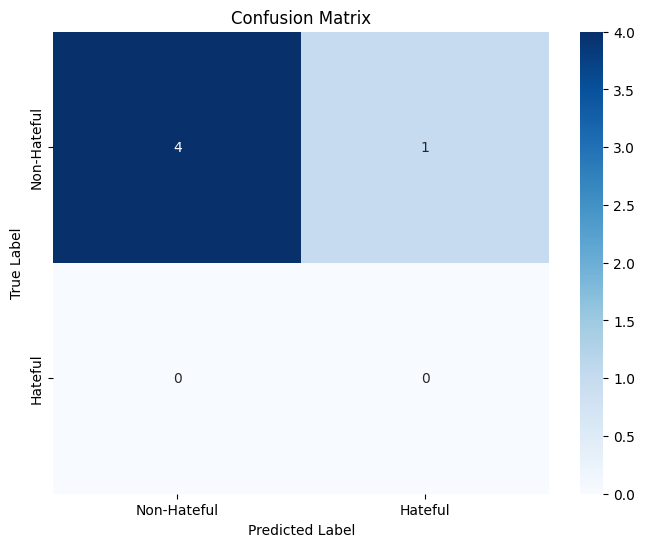

In [62]:
import json
import os
import pandas as pd
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

# Load data from the given JSONL file
def load_data(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

# Save predictions to a CSV file
def save_predictions_to_csv(predictions, output_file):
    df = pd.DataFrame(predictions, columns=['id', 'actual_label', 'predicted_label', 'result', 'reason'])
    df.to_csv(output_file, index=False)
    print(f"Predictions saved to {output_file}")

# Analyze predictions and generate classification metrics
def analyze_results(predictions):
    actual_labels = [entry['actual_label'] for entry in predictions]
    predicted_labels = [entry['predicted_label'] for entry in predictions]

    # Classification report
    report = classification_report(actual_labels, predicted_labels)
    print("Classification Report:\n", report)

    # Accuracy
    accuracy = accuracy_score(actual_labels, predicted_labels)
    print(f"Accuracy: {accuracy:.2f}")
    
    # Precision
    precision = precision_score(actual_labels, predicted_labels, pos_label=1)
    print(f"Precision: {precision:.2f}")

    # Recall
    recall = recall_score(actual_labels, predicted_labels, pos_label=1)
    print(f"Recall: {recall:.2f}")

    # Confusion Matrix
    cm = confusion_matrix(actual_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Hateful', 'Hateful'], yticklabels=['Non-Hateful', 'Hateful'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Main function predict and analyse
def process_memes_and_predict(file_path, img_folder, output_csv):
    # Step 1: Load data from the JSONL file
    data = load_data(file_path)

    # Step 2: Storing the result
    predictions = []
    
    # Start time
    start_time = time.time()
    
    # Define your range here (Avi running for only 5 images)
    for entry in tqdm(data[:5], desc="Processing Memes", unit="image"):
        img_id = entry['id']
        actual_label = entry['label']

        # Step 3: Finding corresponding image file by removing leading zeros from the image ID
        img_name = str(int(img_id)) + ".png"
        img_path = os.path.join(img_folder, img_name)

        # Step 4: Predict using hateful_meme_detection function
        hateful_meme_detection(img_path) 
        # Storing the result        
        predicted_label = prediction_result
        xx = "hateful" if predicted_label == 1 else "non-hateful"

        # Storing the results
        prediction_entry = {
            'id': img_id,
            'actual_label': actual_label,  # Store the actual label from the dataset
            'predicted_label': predicted_label,
            'result': xx,
            'reason': reason
        }
        predictions.append(prediction_entry)
    
    # End Time    
    elapsed_time = time.time() - start_time 
    print(f"Processing completed in {elapsed_time:.2f} seconds.")

    # Step 5: Save results to CSV
    save_predictions_to_csv(predictions, output_csv)

    # Step 6: Analyze results
    analyze_results(predictions)

# Passing necessary datasets
train_file = '/kaggle/input/facebook-hateful-meme-dataset/data/train.jsonl'
img_folder = '/kaggle/input/facebook-hateful-meme-dataset/data/img'  
output_csv_file = '/kaggle/working/results.csv'

process_memes_and_predict(train_file, img_folder, output_csv_file)
